http://krasserm.github.io/2018/03/19/gaussian-processes/

### Kernel

In [1]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


### Prior

[[1.00000000e+00 9.80198673e-01 9.23116346e-01 8.35270211e-01
  7.26149037e-01 6.06530660e-01 4.86752256e-01 3.75311099e-01
  2.78037300e-01 1.97898699e-01 1.35335283e-01 8.89216175e-02
  5.61347628e-02 3.40474547e-02 1.98410947e-02 1.11089965e-02
  5.97602290e-03 3.08871541e-03 1.53381068e-03 7.31802419e-04
  3.35462628e-04 1.47748360e-04 6.25215038e-05 2.54193465e-05
  9.92950431e-06 3.72665317e-06 1.34381228e-06 4.65571572e-07
  1.54975314e-07 4.95640532e-08]
 [9.80198673e-01 1.00000000e+00 9.80198673e-01 9.23116346e-01
  8.35270211e-01 7.26149037e-01 6.06530660e-01 4.86752256e-01
  3.75311099e-01 2.78037300e-01 1.97898699e-01 1.35335283e-01
  8.89216175e-02 5.61347628e-02 3.40474547e-02 1.98410947e-02
  1.11089965e-02 5.97602290e-03 3.08871541e-03 1.53381068e-03
  7.31802419e-04 3.35462628e-04 1.47748360e-04 6.25215038e-05
  2.54193465e-05 9.92950431e-06 3.72665317e-06 1.34381228e-06
  4.65571572e-07 1.54975314e-07]
 [9.23116346e-01 9.80198673e-01 1.00000000e+00 9.80198673e-01
  9.

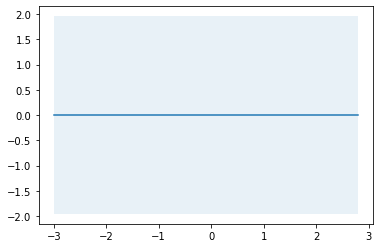

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
        
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
#     for i, sample in enumerate(samples):
#         plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    
    
# Finite number of points
X = np.arange(-3, 3, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

print(cov)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

### Posterior from training data

In [3]:
from numpy.linalg import inv
import numpy as np
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''  
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

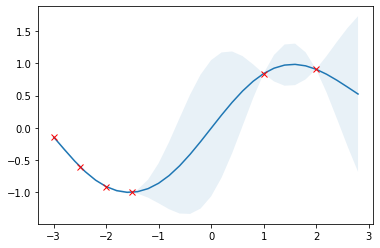

In [4]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)

X_train = np.concatenate((np.arange(-3, -1, 0.5), np.arange(1, 3, 1))).reshape(-1, 1)
Y_train = X_train
Y_train = np.sin(X_train)


# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=1e-8)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.savefig("/home/jleguy/Téléchargements/fig_uncertainty.png", dpi=200)

In [5]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
        
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    

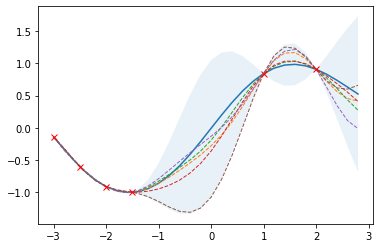

In [8]:
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.savefig("/home/jleguy/Téléchargements/fig_uncertainty_samples.png", dpi=200)